Name: Pranav Khera

Student Number: 24032995

**Part I - "Trading strategy"**

The data cleaning procedure is identical for all FX tick data files as all csv files have the same formatting. The screenshots will show the preprocessing of the EUR/GBP November 2024 tick data but identical steps are taken for the EUR/USD FX data. 

1) Source and unzip the FX data and after viewing the csv files containing the tick data, we remove the 4th column containing 0s only

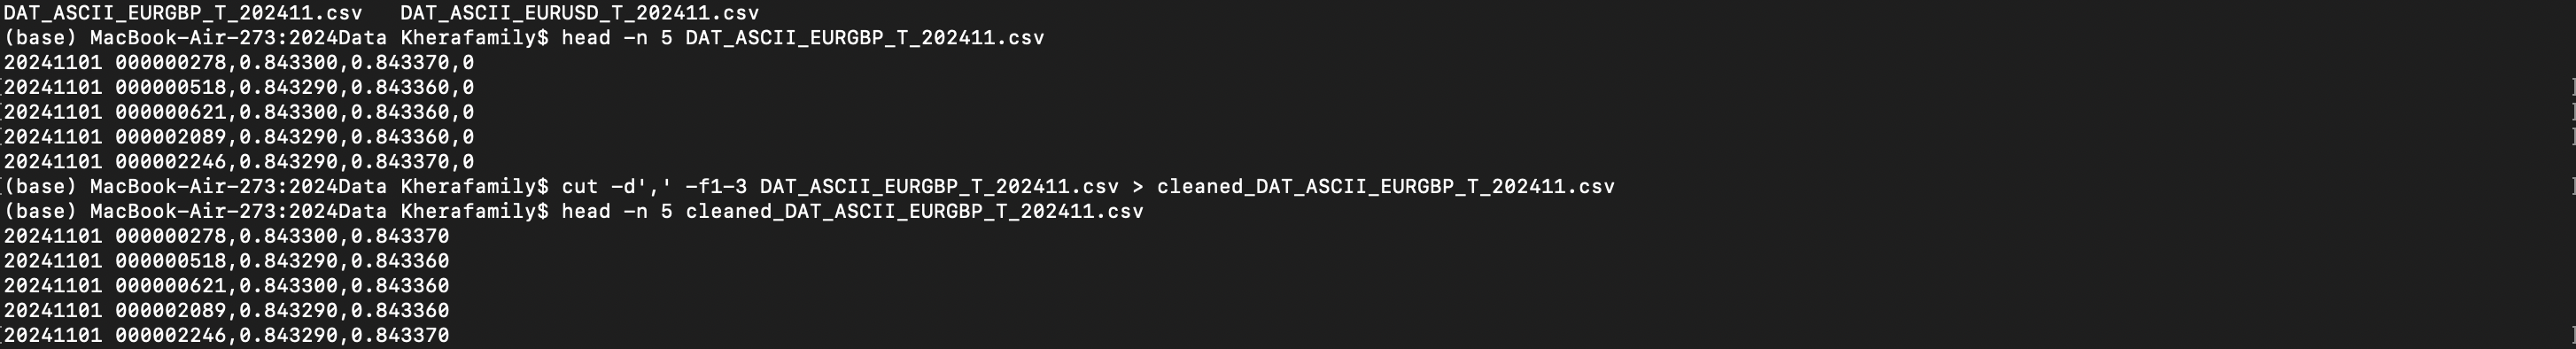

2) We create a new fourth column for the reference (mid) price of our data so we can implement our intrinsic time analysis using this, avoiding the effect of bid-ask bounce

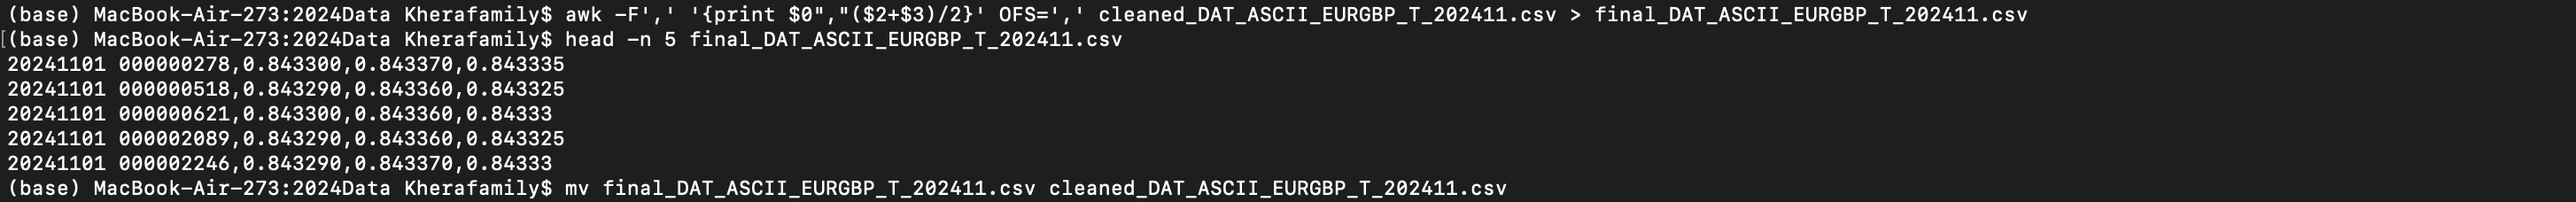

3) We now modify the datetime column to match the standard formating for a 'Pandas' (public Python library) DataFrame.

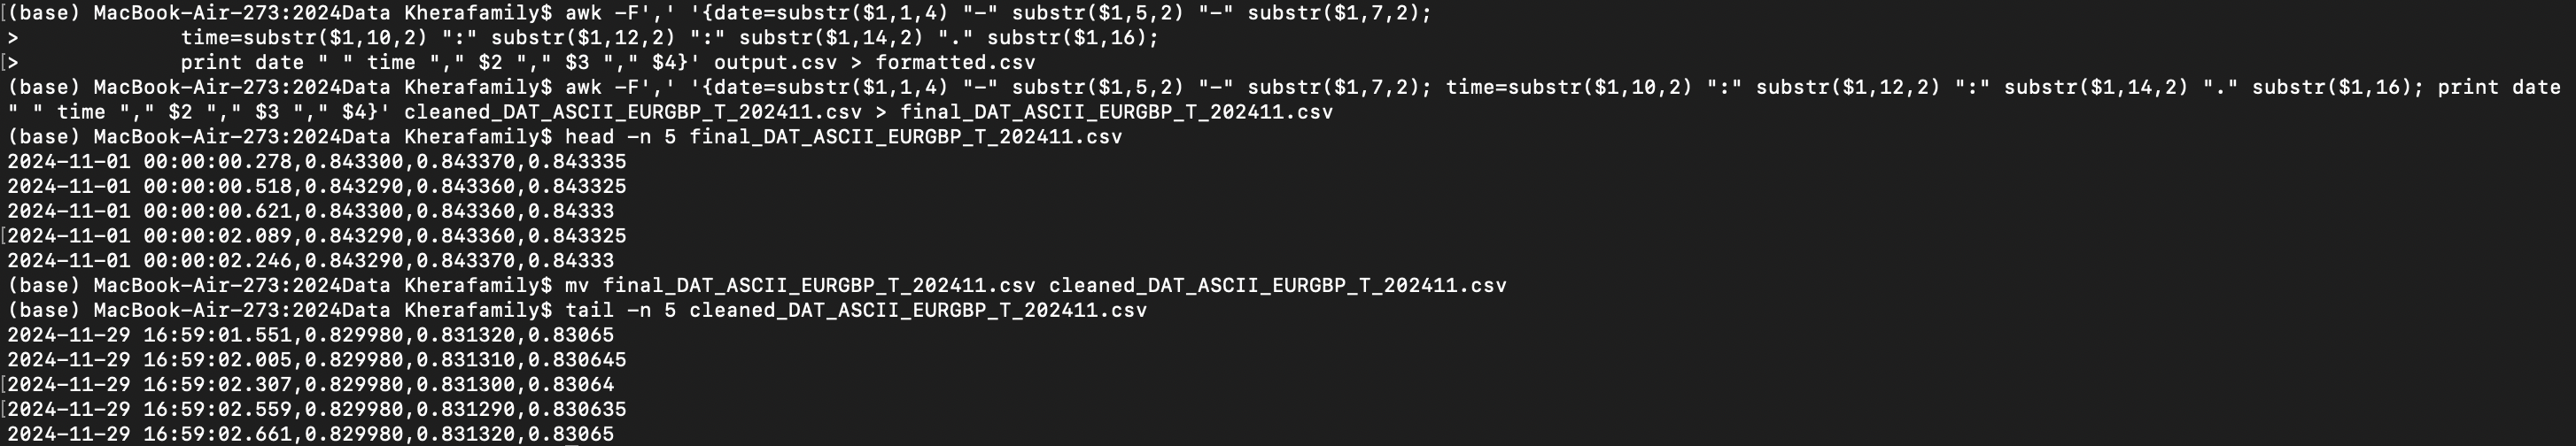




We are now ready to import our cleaned datasets into a Pandas dataframe to implement our trading strategy. Before implementing the strategy, the pseudocode is outline below:

#### Initialization:

- Set initial capital = 1000
- Set trading threshold `θ` (e.g. 0.005)
- Set Intrinsic Time thresholds: delta_up = delta_down = 0.0005
- Define status flags:
  - `position_open` = False
  - `position_type` = None (either "long" or "short")

---

#### Step 1: Generate Intrinsic Time Series & Detect Directional Changes

1. First, use Intrinsic Time thresholds (delta_up, delta_down) to extract a series of event-based prices (i.e. when significant price movements occur).

2. Then, apply Directional Change Detection only on these intrinsic events
   - For each intrinsice price `P_IE`:
     - Check for a Directional Change event:
       - `DC↑` (price increases from extreme by ≥ `θ`): switch trend to "up"
       - `DC↓` (price decreases from extreme by ≥ `θ`): switch trend to "down"
    
3. Record directional changes (`DC↑` or `DC↓`) as trading triggers.

---

#### Step 2: Trade Entry Rules

For each new row in the time series:

- If **no position is open**:
  
  - If `DC↑` occurs:
    - Open long position at current mid-price
    - Set take-profit = entry_price × (1 + `θ` / 2)
    - Set stop-loss = entry_price × (1 - `θ` / 2)
    - Record entry time, entry price, position_type = "long"
  
  - Else if `DC↓` occurs:
    - Open short position at current mid-price
    - Set take-profit = entry_price × (1 - `θ` / 2)
    - Set stop-loss = entry_price × (1 + `θ` / 2)
    - Record entry time, entry price, position_type = "short"

---

#### Step 3: Trade Exit Rules

- If **a position is open**:
  
  - For **long position**:
    - If current price ≥ take-profit OR ≤ stop-loss:
      - Close the position
      - Compute PnL = current_price - entry_price
      - Append trade record with:
        - Entry time, exit time, P_entry, P_exit, PnL, position_type
  
  - For **short position**:
    - If current price ≤ take-profit OR ≥ stop-loss:
      - Close the position
      - Compute PnL = entry_price - current_price
      - Append trade record with: 
        - Entry time, exit time, P_entry, P_exit, PnL, position_type

---

#### Step 4: Backtesting and Evaluation

- Apply the above logic independently to our generated intrinsic time series for:
  - A training dataset (e.g. 60% of the time series)
  - A testing dataset (remaining 40%)
  - A completely unseen testing dataset

- For each set, calculate:

  - Total number of trades
  - Total PnL
  - Win rate = (# of profitable trades / total trades)
  - Average PnL per trade
  - Maximum drawdown
  - Breakdown of long vs. short performance

- Save trade logs to csv files

---

#### Notes:
- Each trade uses full available capital in our model
- Strategy performance can be tuned by adjusting `θ`, delta_up, delta_down

---


Import libraries

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit 

Import our cleaned (and chronological) FX data

In [42]:

#EURUSD2024NOV
file_path = '/Users/Kherafamily/Documents/KCL/HFF/2024Data/cleaned_DAT_ASCII_EURUSD_T_202411.csv'
#EURGBP2024NOV
file_path2 = '/Users/Kherafamily/Documents/KCL/HFF/2024Data/cleaned_DAT_ASCII_EURGBP_T_202411.csv'

df = pd.read_csv(file_path, sep=',', header=None, names=["datetime", "bid", "ask", "mid"])
df2 = pd.read_csv(file_path2, sep=',', header=None, names=["datetime", "bid", "ask", "mid"])

print(df)
print(df2)

                        datetime      bid      ask      mid
0        2024-11-01 00:00:00.090  1.08771  1.08773  1.08772
1        2024-11-01 00:00:00.193  1.08772  1.08774  1.08773
2        2024-11-01 00:00:00.297  1.08773  1.08774  1.08773
3        2024-11-01 00:00:00.400  1.08772  1.08774  1.08773
4        2024-11-01 00:00:02.061  1.08773  1.08774  1.08773
...                          ...      ...      ...      ...
2312768  2024-11-29 16:59:57.159  1.05750  1.05791  1.05770
2312769  2024-11-29 16:59:57.361  1.05749  1.05791  1.05770
2312770  2024-11-29 16:59:57.462  1.05752  1.05794  1.05773
2312771  2024-11-29 16:59:59.070  1.05749  1.05791  1.05770
2312772  2024-11-29 16:59:59.223  1.05748  1.05800  1.05774

[2312773 rows x 4 columns]
                        datetime      bid      ask       mid
0        2024-11-01 00:00:00.278  0.84330  0.84337  0.843335
1        2024-11-01 00:00:00.518  0.84329  0.84336  0.843325
2        2024-11-01 00:00:00.621  0.84330  0.84336  0.843330
3       

Generate our intrinsic time class, which we will use to create the intrinsic time series

In [43]:
class intrinsic_time:
    def __init__(self, delta_up, delta_down):
        self.delta_up = delta_up
        self.delta_down = delta_down
        self.S_ext = None
        self.S_IE = None
        self.mode = "up" 

    def detect_event(self, S_tick):
        if self.S_ext is None:
            self.S_ext = S_tick
            self.S_IE = S_tick
            return 0
        
    
        if self.mode == "up":
            if S_tick - self.S_ext >= self.delta_up:
                self.mode = "down"
                self.S_ext = S_tick
                self.S_IE = S_tick
                return 1
            elif S_tick < self.S_ext:
                self.S_ext = S_tick
                if self.S_IE - self.S_ext >= self.delta_down:
                    self.S_IE = S_tick
                    return -2
            return 0

        elif self.mode == "down":
            if self.S_ext - S_tick >= self.delta_down:
                self.mode = "up"
                self.S_ext = S_tick
                self.S_IE = S_tick
                return -1
            elif S_tick > self.S_ext:
                self.S_ext = S_tick
                if self.S_ext - self.S_IE >= self.delta_up:
                    self.S_IE = S_tick
                    return 2
            return 0

Generate our directional change trading strategy to be used on the intrinsic time series

In [44]:
class directional_change:
    def __init__(self, theta):
        self.theta = theta
        self.P_EXT = None  # Extreme point
        self.mode = "up"  # Up or down trend

    def detect_dc(self, P_c):  # P_c is the current price
        if self.P_EXT is None:
            self.P_EXT = P_c
            return None  # No DC yet
        
        if self.mode == "up":
            if P_c <= self.P_EXT * (1 - self.theta):  # Downward DC
                self.mode = "down"
                self.P_EXT = P_c
                return "DC_down"
            self.P_EXT = max(self.P_EXT, P_c)  # Update extreme in up mode

        elif self.mode == "down":
            if P_c >= self.P_EXT * (1 + self.theta):  # Upward DC
                self.mode = "up"
                self.P_EXT = P_c
                return "DC_up"
            self.P_EXT = min(self.P_EXT, P_c)  # Update extreme in down mode

        return None  # No directional change

Define delta (for intrinsic time) and theta (for directional change) 

In [45]:
delta_up = 0.0005 # thresholds for intrinsic time series
delta_down = 0.0005 # thresholds for intrinsic time series
theta = 0.005 # thresholds or trading

Generate event-time dataframe and detect directional change. It is important to note that since theta is much larger than delta_up and delta_down, there will be far more intrinsic events detected than directional changes

In [46]:
intrinsic_detector = intrinsic_time(delta_up = delta_up, delta_down = delta_down)
dc_detector = directional_change(theta = theta)

df["event"] = [intrinsic_detector.detect_event(mid) for mid in df["mid"]]
df2["event"] = [intrinsic_detector.detect_event(mid) for mid in df2["mid"]]

intrinsic_df = df[df["event"] != 0].copy()
intrinsic_df2 = df2[df2["event"] != 0].copy()

dc_detector = directional_change(theta = theta)
intrinsic_df["directional_change"] = [dc_detector.detect_dc(mid) for mid in intrinsic_df["mid"]]

dc_detector2 = directional_change(theta = theta)
intrinsic_df2["directional_change"] = [dc_detector2.detect_dc(mid) for mid in intrinsic_df2["mid"]]

print(intrinsic_df)
print(intrinsic_df2)

                        datetime      bid      ask      mid  event  \
1194     2024-11-01 00:42:06.377  1.08720  1.08722  1.08721     -2   
4982     2024-11-01 02:03:33.797  1.08758  1.08760  1.08759      1   
6810     2024-11-01 02:39:44.969  1.08726  1.08727  1.08726     -1   
7833     2024-11-01 03:00:00.667  1.08673  1.08675  1.08674     -2   
8757     2024-11-01 03:10:03.925  1.08621  1.08623  1.08622     -2   
...                          ...      ...      ...      ...    ...   
2294020  2024-11-29 13:03:24.982  1.05751  1.05752  1.05751      2   
2294401  2024-11-29 13:06:35.846  1.05729  1.05733  1.05731     -1   
2295700  2024-11-29 13:30:47.698  1.05747  1.05749  1.05748      1   
2301772  2024-11-29 14:53:31.321  1.05800  1.05802  1.05801      2   
2308575  2024-11-29 16:12:17.639  1.05790  1.05792  1.05791     -1   

        directional_change  
1194                  None  
4982                  None  
6810                  None  
7833                  None  
8757          

Plot intrinsic time and directional change events for EUR/USD FX rates, with arrows up and down denoting where up and down directional changes occur respectively

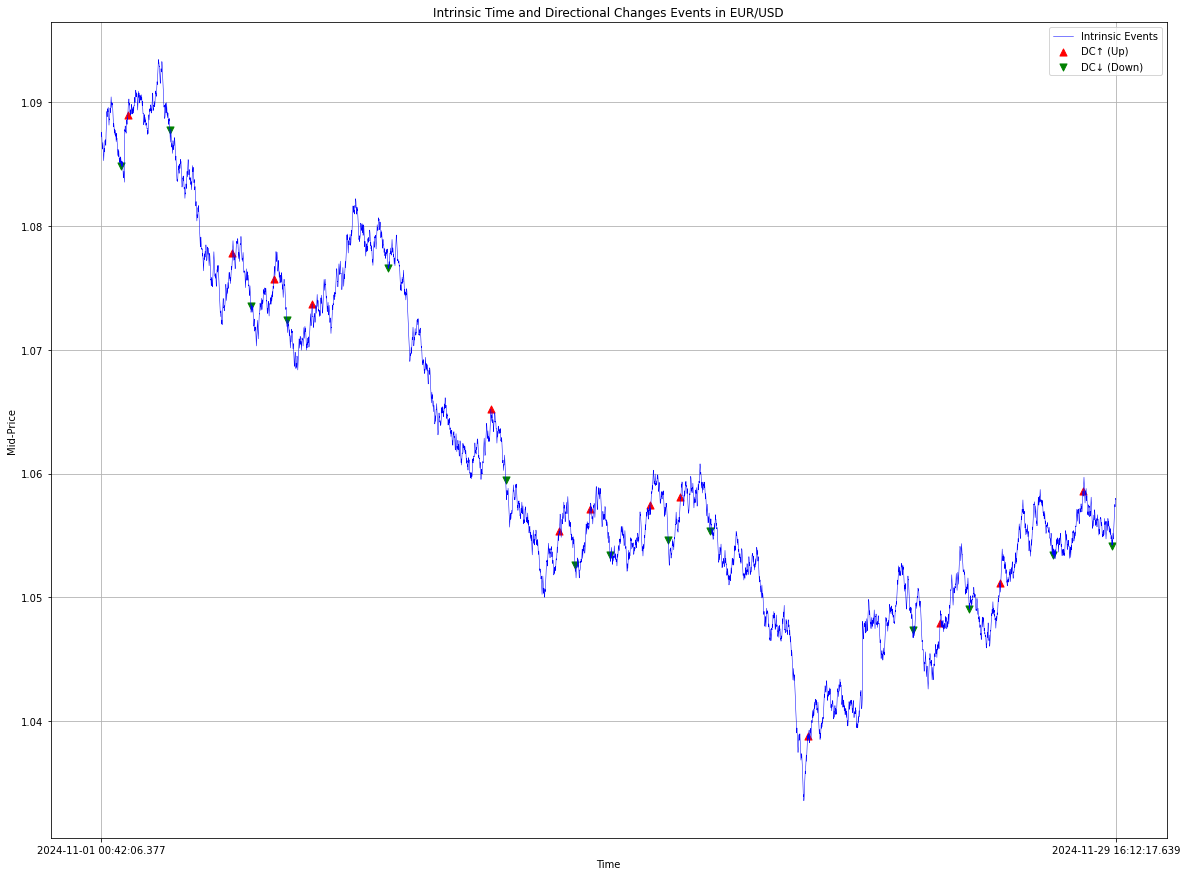

In [47]:
plt.figure(figsize=(20, 15))

# midprice plot optional as a reference
#plt.plot(df["datetime"], df["mid"], linestyle='-', linewidth=0.5, color='gray', label="Mid-Price")
#intrinsic_event
plt.plot(intrinsic_df["datetime"], intrinsic_df["mid"], linestyle='-', linewidth = 0.5, color='blue', label="Intrinsic Events")

# plot dc events
dc_up = intrinsic_df[intrinsic_df["directional_change"] == "DC_up"]
dc_down = intrinsic_df[intrinsic_df["directional_change"] == "DC_down"]
plt.scatter(dc_up["datetime"], dc_up["mid"], color='red', label="DC↑ (Up)", s=50, marker="^")  # Red for up
plt.scatter(dc_down["datetime"], dc_down["mid"], color='green', label="DC↓ (Down)", s=50, marker="v")  # Green for down

# X-axis formatting
plt.xticks([intrinsic_df["datetime"].iloc[0], intrinsic_df["datetime"].iloc[-1]])  # only first and last timestamp

# Other formatting
plt.xlabel("Time")
plt.ylabel("Mid-Price")
plt.title("Intrinsic Time and Directional Changes Events in EUR/USD")
plt.legend()
plt.grid()

# Show the plot
plt.show()

Above: Visual output of directional-change event signals (entry triggers) over the price series

Plot intrinsic time and directional change events for EUR/GBP FX rates, with arrows up and down denoting where up and down directional changes occur respectively

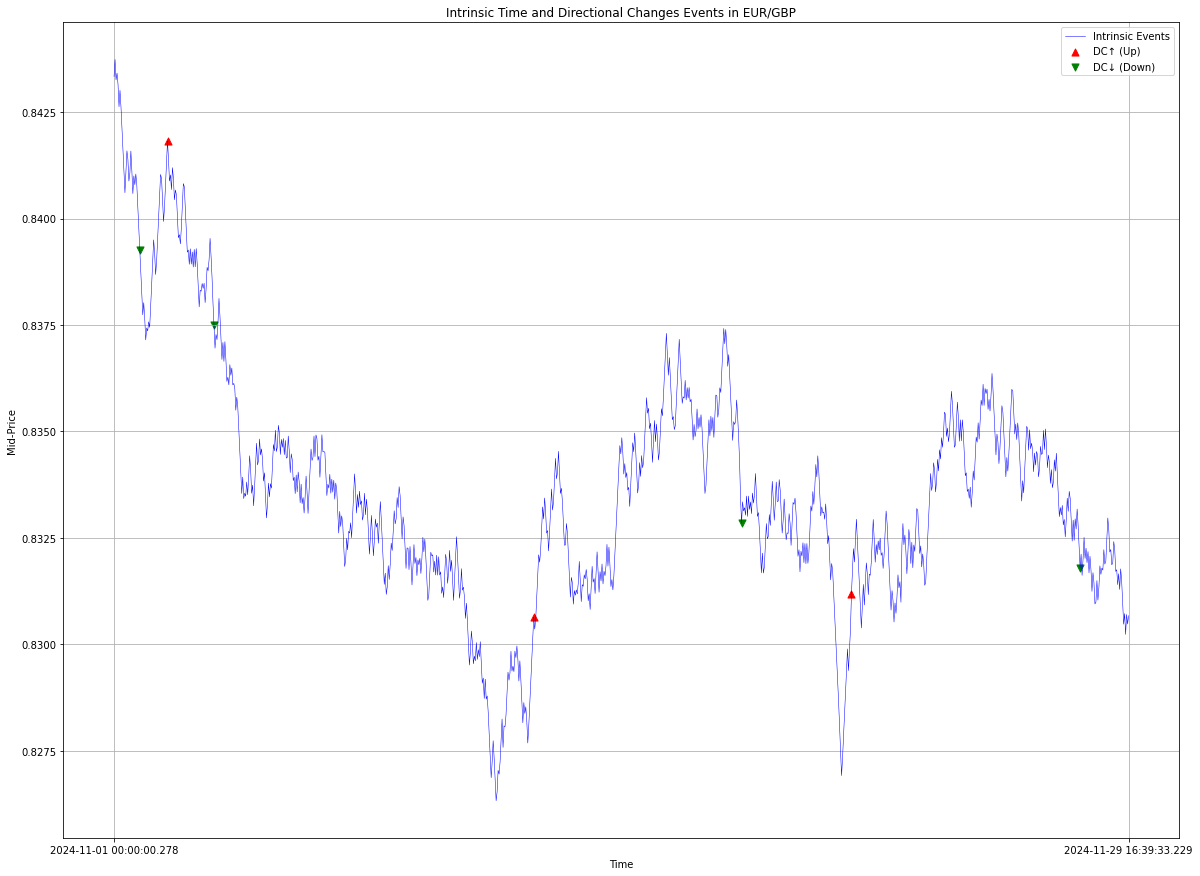

In [48]:
plt.figure(figsize=(20, 15))

# midprice plot optional as a guide
#plt.plot(df2["datetime"], df2["mid"], linestyle='-', linewidth=0.5, color='gray', label="Mid-Price")
#intrinsic_event
plt.plot(intrinsic_df2["datetime"], intrinsic_df2["mid"], linestyle='-', linewidth = 0.5, color='blue', label="Intrinsic Events")

# plot dc events
dc_up = intrinsic_df2[intrinsic_df2["directional_change"] == "DC_up"]
dc_down = intrinsic_df2[intrinsic_df2["directional_change"] == "DC_down"]
plt.scatter(dc_up["datetime"], dc_up["mid"], color='red', label="DC↑ (Up)", s=50, marker="^")  # Red for up
plt.scatter(dc_down["datetime"], dc_down["mid"], color='green', label="DC↓ (Down)", s=50, marker="v")  # Green for down

# X-axis formatting
plt.xticks([intrinsic_df2["datetime"].iloc[0], intrinsic_df2["datetime"].iloc[-1]])  # only first and last timestamp

# Other formatting
plt.xlabel("Time")
plt.ylabel("Mid-Price")
plt.title("Intrinsic Time and Directional Changes Events in EUR/GBP")
plt.legend()
plt.grid()

# Show the plot
plt.show()

Above: Visual output of directional-change event signals (entry triggers) over the price series

**Part II: "Testing your strategy"**

Set up training and test set - ensure that thresholds aren't too large such that no directional changes are detected

In [49]:
if "directional_change" not in intrinsic_df.columns:
    raise ValueError(" no 'directional_change' detected")

if "directional_change" not in intrinsic_df2.columns:
    raise ValueError(" no 'directional_change' detected")

train_size = int(len(intrinsic_df)*0.6)
train_df = intrinsic_df.iloc[:train_size].copy() # train on a portion of EUR/USD data
test_df = intrinsic_df.iloc[train_size:].copy() # test on remaining portion
test_df2 = intrinsic_df2.copy() # use entire EUR/GBP data as a test set



### **Backtesting Procedure**

We evaluate the strategy on each FX dataset using the following steps:

---

#### **1. Preprocessing**
- Load cleaned mid-price data.
- Detect Intrinsic Events using fixed tick thresholds:  
  'δ_up' and 'δ_down'.
- Construct an event-based time series from these intrinsic events.

---

#### **2. Event Detection**
- Apply the Directional Change (DC) algorithm on the intrinsic time series, using a proportional threshold `θ`.
- Label each intrinsic event point as either `DC↑` (upward change) or `DC↓` (downward change).

---

#### **3. Train-Test Split**
- Split the intrinsic event time series into:
  - Training set (e.g. first 60%)
  - Testing set (remaining 40%)

---

#### **4. Strategy Execution**
- On each `DC↑`:
  - Open a long position (if no position is already open)
- On each `DC↓`:
  - Open a short position (if no position is already open)
- Use static take-profit and stop-loss levels, calculated based on the entry price and threshold `θ`.

---

#### **5. Trade Management**
- Track each open trade:
  - Monitor until price hits take-profit or stop-loss level.
- Upon exit, record:
  - Entry/exit price and time  
  - Position type  
  - Trade size  
  - Profit or loss (PnL)

---

#### **6. Logging and Export**
- Save full trade logs to csv files:
  - Separate logs for training and testing phases.
  - Optionally split further into long and short trade logs.

---

#### **7. Performance Evaluation**
- Compute key performance metrics for each dataset:
  - Total number of trades
  - Total PnL
  - Win rate
  - Average PnL per trade
  - Maximum drawdown
  - Long vs. short performance breakdown

Below is the python implementation


In [50]:
def backtest_strategy(data):
    capital = 1000
    # Initialize Trading Strategy Variables 
    position_open = False
    position_type = None 
    P_entry = None
    P_DCC_up = None
    take_profit_level = None
    stop_loss_level = None
    trades = []

    theta = 0.005  # Same theta used in lab8.py
    # Execute Trading Logic
    for index, row in data.iterrows():
        current_price = row["mid"]

        # Open trade if DC↑ occurs and no trade is open
        if row["directional_change"] == "DC_up" and not position_open:
            P_entry = current_price
            P_DCC_up = current_price
            take_profit_level = P_DCC_up * (1 + theta / 2)
            stop_loss_level = P_DCC_up * (1 - theta / 2)
            entry_time = row["datetime"]
            position_open = True
            position_type = "long"
        
        elif row["directional_change"] == "DC_down" and not position_open:
            P_entry = current_price
            P_DCC = current_price
            take_profit_level = P_DCC * (1 - theta / 2)  # Profit when price drops
            stop_loss_level = P_DCC * (1 + theta / 2)  # Stop loss when price rises
            entry_time = row["datetime"]
            position_open = True
            position_type = "short"

        # Exit trade if price hits take profit or stop loss
        elif position_open:
            if position_type == "long":
                if current_price >= take_profit_level or current_price <= stop_loss_level:
                    exit_price = current_price
                    exit_time = row["datetime"]
                    position_size = capital / P_entry
                    PnL = position_size * (exit_price - P_entry)  

                    trades.append({
                        "entry_time": entry_time,
                        "exit_time": exit_time,
                        "position_type": position_type,
                        "P_entry": P_entry,
                        "exit_price": exit_price,
                        "PnL": PnL,
                        "capital_used": capital,
                        "position_size": position_size
                    })

                    position_open = False

            elif position_type == "short":
                if current_price <= take_profit_level or current_price >= stop_loss_level:
                    exit_price = current_price
                    exit_time = row["datetime"]
                    position_size = capital / P_entry
                    PnL = position_size * (P_entry - exit_price)
  

                    trades.append({
                        "entry_time": entry_time,
                        "exit_time": exit_time,
                        "position_type": position_type,
                        "P_entry": P_entry,
                        "exit_price": exit_price,
                        "PnL": PnL,
                        "capital_used": capital,
                        "position_size": position_size
                    })

                    position_open = False

    return pd.DataFrame(trades)




Obtain backtesting results from our training set and 2 test sets

In [51]:
train_trades = backtest_strategy(train_df)
test_trades = backtest_strategy(test_df)
test_trades2 = backtest_strategy(test_df2)

Performance analysis on the 3 datasets

In [52]:
def evaluate_performance(trades_df, dataset_name="Dataset"):
    # Performance Analysis 
    total_trades = len(trades_df)
    total_profit = trades_df["PnL"].sum()
    win_rate = (trades_df["PnL"] > 0).mean() * 100
    avg_profit = trades_df["PnL"].mean()
    max_drawdown = trades_df["PnL"].min()

    long_trades = trades_df[trades_df["position_type"] == "long"]
    short_trades = trades_df[trades_df["position_type"] == "short"]

    # Print results
    print(f"Performance on {dataset_name}:")
    print(f"Total Trades: {total_trades}")
    print(f"Total PnL: {total_profit:.5f}")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Average PnL per Trade: {avg_profit:.5f}")
    print(f"Max Drawdown (Largest Loss): {max_drawdown:.5f}")
    print("-" * 50)


    print("Breakdown:")
    print(f"Long Trades: {len(long_trades)}, PnL: {long_trades['PnL'].sum():.5f}")
    print(f"Short Trades: {len(short_trades)}, PnL: {short_trades['PnL'].sum():.5f}")
    print("=" * 50)

evaluate_performance(train_trades, "Training Set (EUR/USD)")
evaluate_performance(test_trades, "Testing Set 1 (EUR/USD)")
evaluate_performance(test_trades2, "Testing Set 2 (EUR/GBP)")

Performance on Training Set (EUR/USD):
Total Trades: 18
Total PnL: 5.07327
Win Rate: 55.56%
Average PnL per Trade: 0.28185
Max Drawdown (Largest Loss): -2.80038
--------------------------------------------------
Breakdown:
Long Trades: 9, PnL: 2.85076
Short Trades: 9, PnL: 2.22252
Performance on Testing Set 1 (EUR/USD):
Total Trades: 8
Total PnL: 0.04916
Win Rate: 50.00%
Average PnL per Trade: 0.00614
Max Drawdown (Largest Loss): -2.84343
--------------------------------------------------
Breakdown:
Long Trades: 4, PnL: 4.94840
Short Trades: 4, PnL: -4.89924
Performance on Testing Set 2 (EUR/GBP):
Total Trades: 6
Total PnL: 10.57195
Win Rate: 83.33%
Average PnL per Trade: 1.76199
Max Drawdown (Largest Loss): -2.70246
--------------------------------------------------
Breakdown:
Long Trades: 3, PnL: 2.59282
Short Trades: 3, PnL: 7.97913


Saving results

In [53]:
# Save Results 
train_trades.to_csv("train_trading_results.csv", index=False)
test_trades.to_csv("test_trading_results.csv", index=False)
test_trades2.to_csv("test2_trading_results.csv", index=False)


train_trades[train_trades["position_type"] == "long"].to_csv("train_long_trades.csv", index=False)
train_trades[train_trades["position_type"] == "short"].to_csv("train_short_trades.csv", index=False)

test_trades[test_trades["position_type"] == "long"].to_csv("test_long_trades.csv", index=False)
test_trades[test_trades["position_type"] == "short"].to_csv("test_short_trades.csv", index=False)

test_trades2[test_trades2["position_type"] == "long"].to_csv("test2_long_trades.csv", index=False)
test_trades2[test_trades2["position_type"] == "short"].to_csv("test2_short_trades.csv", index=False)

**500-word discussion on empirical results and whether they suggest some modifications to the trading strategy**

**Intro**

The trading strategy developed in this project is designed using the intrinsic time framework. Rather than advancing time uniformly, intrinsic time progresses only when significant price movements (directional changes) occur. Specifically, directional change (DC) events serve as intrinsic time “ticks.” This structure allows the strategy to filter market microstructure noise and focus on economically significant movements.

The algorithm monitors price movements and triggers a long trade when the price increases by a threshold θ (upward directional change) and a short trade when it decreases by θ (downward directional change). Each trade uses the entire capital of 1000 units, and exits are made at predefined take-profit or stop-loss levels derived from θ. Results are computed across training and two test sets.

**Empirical results**

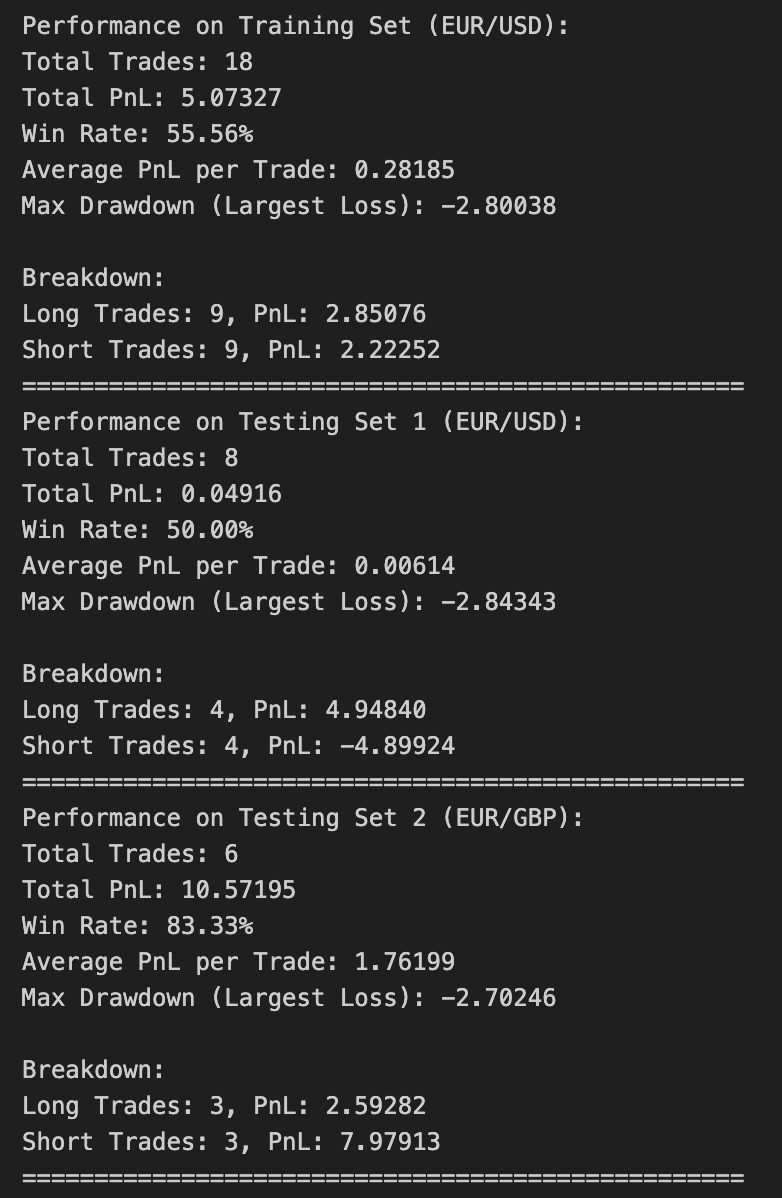

Performance was positive across all sets, with higher precision on the EUR/GBP dataset. The increased number of trades in the first test set suggests that the absolute intrinsic time thresholds (i.e. tick-based δ) may have captured more frequent intrinsic events due to larger absolute price fluctuations. However, since θ is a proportional threshold, the directional change detection remains sensitive to relative, rather than absolute, movements. This indicates that volatility in percentage terms may have also been higher. 

While there is a slight overfit risk (θ was tuned on the training set), generalisation remained robust. The consistency across markets also reflects strategy productivity, which is defined as performance across different instruments or market conditions.

**Strategy Evaluation**

Despite profitability, refinements could be made. Using absolute thresholds (e.g. δ = 0.0005) means the strategy is sensitive to the scale of the currency pair. A more robust alternative is to set both δ and θ as fractions or percentages of the price, making the model scale-invariant and better suited across FX instruments.

Secondly, a trailing stop loss could dynamically adjust to favourable price movement while preserving gains, improving risk-adjusted returns and drawdown resilience. The current use of fixed stop levels may be suboptimal in fast markets (characterised by clustered volatility and low durations).

Further, the strategy currently allocates 100% of capital per trade. A fractional capital allocation model, incorporating position sizing rules, could help reduce tail risk and improve capital efficiency.

Finally, given our reliance on the mid-price (to avoid bid-ask bounce), one potential direction is to integrate implementation shortfall analysis into the performance evaluation. This would reflect more realistic costs and connect our model to algorithmic execution frameworks (e.g., TWAP, VWAP).




